In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
#from matplotlib.mlab import griddata

In [46]:
def flipLabels(Y, perc):

    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [47]:
# set the parameters for data generation

n = 200 # number of points per class
D = 2 # dimension of the points

# linear case
m = 0.9
q = 0

# bounds (assume they are the same for all dimensions)
low_D = -10
high_D = 10

Class 1:  93
Class 2:  107


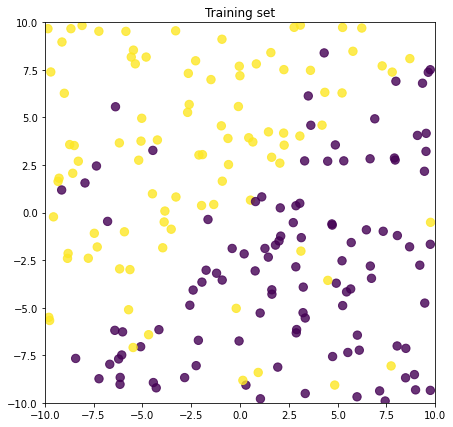

In [48]:
##### GENERATE A TRAINING SET #####

X = np.zeros((n, D))
Y = np.zeros(n)

# sampling of the X
for i in range(D):
    X[:,i] = np.random.uniform(low_D, high_D, size=n)
    
# assigning the labels depending on the position of the sample with respect to the linear separator
Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
Y[Y==0] = -1

# add some noise
Yn = flipLabels(Y, 10)

Xtr = X
Ytr = Yn

fig = plt.figure(figsize=(7,7)) 
plt.title("Training set")
plt.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)
#plt.plot(Xtr[:,0], Xtr[:,0] * m + q) # Forget about this
plt.xlim((low_D, high_D))
plt.ylim((low_D, high_D))

print('Class 1: ', np.count_nonzero(Ytr == 1))
print('Class 2: ',np.count_nonzero(Ytr == -1))

(-10.0, 10.0)

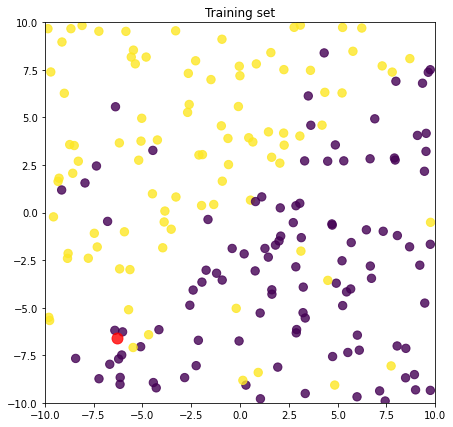

In [49]:
# Generate and plot a new point

Xnew = np.zeros((1, D))
Ynew = np.zeros(1)

# sampling of the X
for i in range(D):
    Xnew[:,i] = np.random.uniform(low_D, high_D, size=1)
    
# assigning the labels depending on the position of the sample with respect to the linear separator
Ynew[Xnew[:,1] - (Xnew[:,0] * m + q) > 0] = 1 
Ynew[Ynew==0] = -1

fig = plt.figure(figsize=(7,7)) 
plt.title("Training set")
plt.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)
plt.scatter(Xnew[:,0], Xnew[:,1], s=120, c='r', alpha=0.8)
plt.xlim((low_D, high_D))
plt.ylim((low_D, high_D))

In [50]:
def sqDist(X1, X2):
    """Computes all the distances between two set of points stored in two matrices
    usage: D = sqDist(X1, X2)
    Arguments:
    X1: a matrix of size [n1xd], where each row is a d-dimensional point
    X2: a matrix of size [n2xd], where each row is a d-dimensional point
    Returns:
    D: a [n1xn2] matrix where each element (D)_ij is the distance between points (X_i, X_j)
    """
    sqx = np.sum(np.multiply(X1, X1), 1)
    sqy = np.sum(np.multiply(X2, X2), 1)
    return np.outer(sqx, np.ones(sqy.shape[0])) + np.outer(np.ones(sqx.shape[0]), sqy.T) - 2 * np.dot(X1, X2.T)

Estimated output:  -1.0
True output:  -1.0


(-10.0, 10.0)

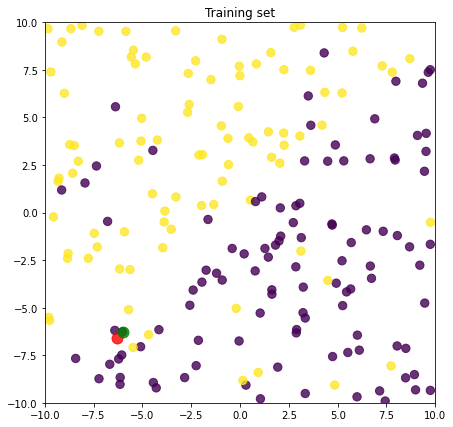

In [51]:
d = sqDist(Xtr, Xnew)
idx=np.argmin(d)

print('Estimated output: ', Ytr[idx])
print('True output: ', Ynew[0])

fig = plt.figure(figsize=(7,7)) 
plt.title("Training set")
plt.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)
plt.scatter(Xnew[:,0], Xnew[:,1], s=120, c='r', alpha=0.8) # new point
plt.scatter(Xtr[idx,0], Xtr[idx,1], s=120, c='g', alpha=0.8) # closest
plt.xlim((low_D, high_D))
plt.ylim((low_D, high_D))

In [52]:
k = 9
s = np.sort(d,0)
idx = np.argsort(d.reshape(1,len(d)))
#print(idx.transpose())
#print(idx[0,0:k])
print(Ytr[idx[0,0:k]])
#print(np.sign(np.mean(Ytr[idx[0,0:k]])))

[-1. -1. -1.  1. -1. -1. -1.  1.  1.]


(-10.0, 10.0)

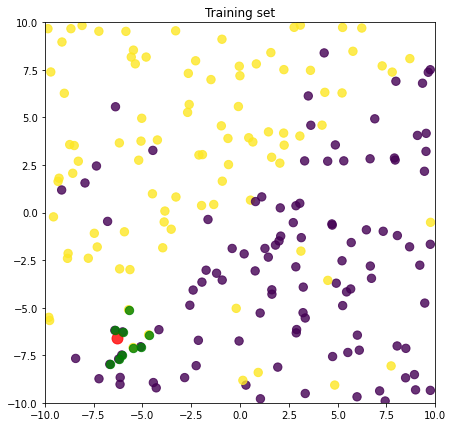

In [53]:
fig = plt.figure(figsize=(7,7)) 
plt.title("Training set")
plt.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)
plt.scatter(Xnew[:,0], Xnew[:,1], s=120, c='r', alpha=0.8)
plt.scatter(Xtr[idx[0,0:k],0], Xtr[idx[0,0:k],1], s=70, c='g', alpha=0.8)
plt.xlim((low_D, high_D))
plt.ylim((low_D, high_D))

In [54]:
def kNNClassify(Xtr, Ytr, k, Xte):
    """Classifies a set o test points given a training set and the number of neighbours to use
    usage:
    Ypred = kNNClassify(Xtr, Ytr, k=5, Xte)
    Arguments:
    Xtr: Training set matrix [nxd], each row is a point
    Ytr: Training set label array [n], values must be +1,-1
    k: Number of neighbours
    Xte: Test points
    Return
    Ypred: estimated test output
    """
    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if any(np.abs(Ytr) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    dist = sqDist(Xte, Xtr)

    for idx in range(n_test):
        neigh_indexes = np.argsort(dist[idx, :])[:k]
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = np.sign(avg_neigh) # Notice this is for binary classification

    return Ypred

In [58]:
import matplotlib.tri as tri
def separatingFkNN(Xtr, Ytr, k):
    """Plots seprating function of a kNN classifier
    usage: separatingFkNN(Xtr=X, Ytr=Y, k=3)
    Xtr: The training points
    Ytr: The labels of the training points
    k : How many neighbours to use for classification
    Returns:
    nothing"""

    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xtr)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, Ypred)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    
    #zi = griddata(x, y, Ypred, xi, yi, interp='linear')
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])

    
    # plot data points.
    plt.scatter(x, y, c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)
    plt.grid(True)

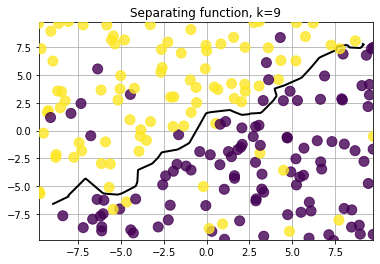

In [59]:
k=9
separatingFkNN(Xtr, Ytr, k)

In [22]:
d = [8, 3, 9, 1, 0, 5]
s = np.sort(d)
Is = np.argsort(d)
print(d)
print(s)
print(Is)

[8, 3, 9, 1, 0, 5]
[0 1 3 5 8 9]
[4 3 1 5 0 2]


Class 1:  102
Class 2:  98


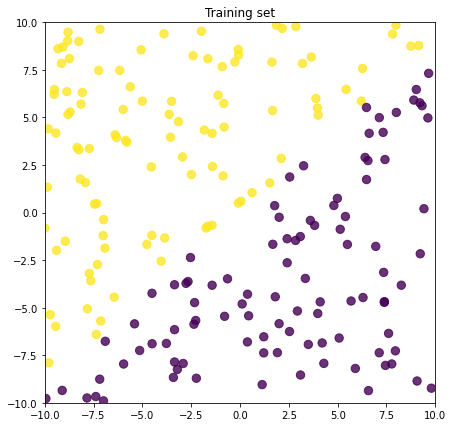

In [61]:
##### GENERATE A TEST SET #####

X = np.zeros((n, D))
Y = np.zeros(n)

# sampling of the X
for i in range(D):
    X[:,i] = np.random.uniform(low_D, high_D, size=n)
    
# assigning the labels depending on the position of the sample with respect to the linear separator
Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
Y[Y==0] = -1

Xte = X
Yte = Y

fig = plt.figure(figsize=(7,7)) 
plt.title("Training set")
plt.scatter(Xte[:,0], Xte[:,1], s=70, c=Yte, alpha=0.8)
plt.xlim((low_D, high_D))
plt.ylim((low_D, high_D))

print('Class 1: ', np.count_nonzero(Yte == 1))
print('Class 2: ',np.count_nonzero(Yte == -1))

In [62]:
Ks = np.arange(1,123,2)
Acc = np.zeros(len(Ks)).reshape(1,len(Ks)).transpose()
for k in np.arange(len(Ks)):
    Ypred = kNNClassify(Xtr, Ytr, Ks[k], Xte)
    Acc[k] = np.count_nonzero(Ypred.reshape(1,n)==Yte.reshape(1,n))/len(Yte)

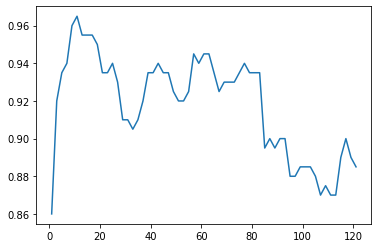

In [63]:
plt.plot(Ks, Acc)